In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import SGD
import nltk
# nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import difflib
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import argparse
import pickle 
import os
from pycocotools.coco import COCO
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
import random
import zlib
from sklearn import svm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pingyihu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open("data/vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(256, 512, len(vocab), 1)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
decoder.load_state_dict(torch.load('models/decoder-5-3000.pkl'))

<All keys matched successfully>

In [3]:
# image loader
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [17]:
# compare captioning and output captioning by cosine similarity
def cosine_S(str_a, str_b):
    word_set = list(set(str_a).union(set(str_b)))
    word_dict = dict()
    i = 0
    for word in word_set:
        word_dict[word] = i
        i += 1
    s1_cut_code = [word_dict[word] for word in str_a]
    s1_cut_code = [0]*len(word_dict)
    s2_cut_code = [word_dict[word] for word in str_b]
    s2_cut_code = [0]*len(word_dict)
    for word in str_a:
        s1_cut_code[word_dict[word]]+=1
    for word in str_b:
        s2_cut_code[word_dict[word]]+=1
    # cosine similarity
    sum = 0
    sq1 = 0
    sq2 = 0
    for i in range(len(s1_cut_code)):
        sum += s1_cut_code[i] * s2_cut_code[i]
        sq1 += pow(s1_cut_code[i], 2)
        sq2 += pow(s2_cut_code[i], 2)
    try:
        result = round(float(sum) / (math.sqrt(sq1) * math.sqrt(sq2)), 2)
    except ZeroDivisionError:
        result = 0.0
    return result

In [18]:
# compare input captioning and output captioning by Jaccard similarity
def jaccard(str_a, str_b): 
    set_intersection = list(set(str_a).intersection(set(str_b)))
    set_union = list(set(str_a).union(set(str_b)))
#     print(set_intersection)
#     print(set_union)
    return len(set_intersection)/len(set_union)*1.0

In [10]:
test_a = [1,4,2,2]
test_b = [2,3,3,4,4]
res = jaccard(test_a,test_b)
print(res)
tuple_test = (1,2,[1,2,3])
print(tuple_test[2])
a,b,c = tuple_test
print(c)

0.5
[1, 2, 3]
[1, 2, 3]


In [13]:
# count perplexity
def perplexity(image_name):
    # Prepare an image
    image = load_image(image_name, transform)
    image_tensor = image.to(device)
    # Generate an caption from the image
    feature = encoder(image_tensor)
    probs,sampled_ids = decoder.sample(feature)
    probs = probs[0].cpu().numpy()
    sampled_ids = sampled_ids[0].cpu().numpy()
    i = 0;
    prob = 1.0;
    sampled_caption = []
    # print(sampled_ids)
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word not in stopwords.words():
            if word != '<start>':
                prob = prob * probs[i]
        if word == '<end>':
            break
        i = i + 1    
    if '<start>' in sampled_caption:
        sampled_caption.remove('<start>')
    if '<end>' in sampled_caption:
        sampled_caption.remove('<end>')
    # print(sampled_caption)
    prob = math.pow(prob, -1.0/(i+1))
    sentence = ''
    sentence = ' '.join(sampled_caption)
    comp_rate = len(zlib.compress(bytes(sentence, 'utf-8')))
    sentence = bytes(sentence, encoding='utf8')
    # print(sentence)
    return prob, comp_rate, sampled_caption

In [52]:
# getting feature vector
def getting_feature(image_name):
    n = len(vocab.word2idx)
    word_feature = np.zeros([n,])
    # Prepare an image
    image = load_image(image_name, transform)
    image_tensor = image.to(device)
    # get image feature
    feature = encoder(image_tensor)
    image_feature = feature[0].detach().numpy()
    image_feature = image_feature.reshape(256,)
    # Generate an caption from the image
    probs,sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word != '<start>':
            word_feature[word_id] += 1
        if word == '<end>':
            break
    return image_feature, word_feature

In [55]:
# test
#c = perplexity("png/image02.png")
a,b = getting_feature("png/image02.png")
print(a.shape)
print(b.shape)
for word in b:
    if word != 0:
        print(word)

(256,)
(9956,)
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
1.0


In [16]:
# load data in flickr 8kb'a
flickr = pd.read_csv('archive/captions.csv')
flickr.columns = ['image_name', 'caption']
flickr = flickr.values.tolist()
random.shuffle(flickr)
for i in range(10):
    print(flickr[i])

['3425414048_fa14d33067.jpg', 'A boy in a New York Mets shirt sitting on a toy Harly Davison motorcycle on a tennis court .']
['3324056835_84904fe2f8.jpg', 'Six dogs walking beside the beach .']
['3169777863_d745865784.jpg', 'A group of dancers wearing black spandex are dancing in a studio .']
['2335619125_2e2034f2c3.jpg', 'A black dog with his mouth open and tongue out runs across an expanse of snow .']
['130211457_be3f6b335d.jpg', 'Two woman posing with a guy .']
['101669240_b2d3e7f17b.jpg', 'A man skis past another man displaying paintings in the snow .']
['2954525375_9d5ca97341.jpg', 'A male walks on the graffiti wall .']
['2546959333_23b957988f.jpg', 'The large brown dog is playing in the grass with a brown cow .']
['241346352_c5a0ea43c6.jpg', 'A male wearing a football uniform kicking a football during a football game .']
['3343311201_eeb1a39def.jpg', "The lady holds her paintbrush next to the artist 's easel ."]


loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


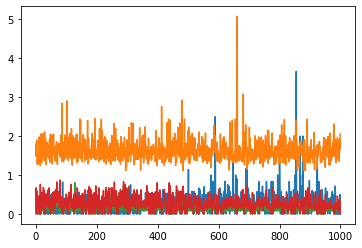

In [58]:
# using SVM or perceptron to train metric_MI:
train_coco = COCO("data/annotations/captions_train2014.json")
val_coco = COCO("data/annotations/captions_val2014.json")
train_ids = list(train_coco.anns.keys())
val_ids = list(val_coco.anns.keys())
random.shuffle(train_ids)
random.shuffle(val_ids)
# print(in_sample[0])
MI_data = [] 
MI_label = []
a = 1.0
b = 1.0
ids = []
sample_size = 500
# get sample in 'in' set
for i in range(sample_size):
    annsid = train_ids[i]
    img_id = train_coco.anns[annsid]['image_id']
    caption = train_coco.anns[annsid]['caption']
    image_path = "data/train2014/" + train_coco.loadImgs(img_id)[0]['file_name']
    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    ori_caption = []
    ori_caption_nostopwords = []
    ori_caption.extend([token for token in tokens])
    ori_caption_nostopwords.extend([token for token in tokens if not token in stopwords.words()])
    (prob,zlib_entropy,gen_caption) = perplexity(image_path)
    gen_caption_nostopwords = []
    gen_caption_nostopwords.extend([token for token in gen_caption if not token in stopwords.words()])
    J_similarity = jaccard(ori_caption_nostopwords, gen_caption_nostopwords)
    C_similarity = cosine_S(ori_caption_nostopwords, gen_caption_nostopwords)
    comp_length = abs(len(ori_caption)-len(gen_caption))/len(ori_caption)*1.0
    MI_data.append([comp_length, prob, J_similarity, C_similarity])
    MI_label.append(1)
# get sample in 'out' set
for i in range(sample_size):
    image_id = flickr[i][0]
    caption = flickr[i][1]
    image_path = 'archive/Images/' + image_id
    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    ori_caption = []
    ori_caption_nostopwords = []
    ori_caption.extend([token for token in tokens])
    ori_caption_nostopwords.extend([token for token in tokens if not token in stopwords.words()])
    (prob,zlib_entropy,gen_caption) = perplexity(image_path)
    gen_caption_nostopwords = []
    gen_caption_nostopwords.extend([token for token in gen_caption if not token in stopwords.words()])
    J_similarity = jaccard(ori_caption_nostopwords, gen_caption_nostopwords)
    C_similarity = cosine_S(ori_caption_nostopwords, gen_caption_nostopwords)
    comp_length = abs(len(ori_caption)-len(gen_caption))/len(ori_caption)*1.0
    MI_data.append([comp_length, prob, J_similarity, C_similarity])
    MI_label.append(-1)
data_train = np.array(MI_data)
label_train = np.array(MI_label)
index = np.array(list(range(sample_size*2)))
plt.plot(index, MI_data)

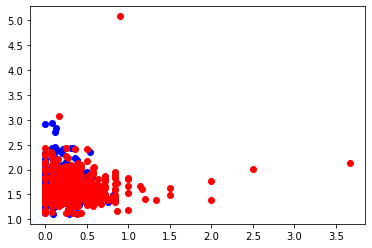

In [67]:
# blue-in
plt.scatter(data_train[0:sample_size-1,0], data_train[0:sample_size-1,1], color="blue")
# red-out
plt.scatter(data_train[sample_size:2*sample_size-1,0], data_train[sample_size:2*sample_size-1,1], color="red")

plt.show()

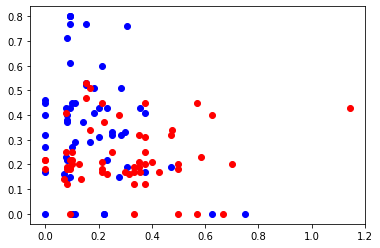

In [43]:
plt.scatter(data_train[0:sample_size-1,0], data_train[0:sample_size-1,2], color="blue")

plt.scatter(data_train[sample_size:2*sample_size-1,0], data_train[sample_size:2*sample_size-1,2], color="red")

plt.show()

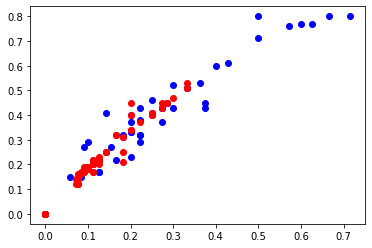

In [44]:
plt.scatter(data_train[0:sample_size-1,1], data_train[0:sample_size-1,2], color="blue")

plt.scatter(data_train[sample_size:2*sample_size-1,1], data_train[sample_size:2*sample_size-1,2], color="red")

plt.show()

In [61]:
data_test = data_train
label_test = label_train
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.layer = nn.Linear(4, 1)
        
    def forward(self, x):
        x = self.layer(x)
        return x
    
def loss_func(scores, label, type="svm"):
    assert type=="perceptron" or type=="svm", "loss type error"
    if type == "perceptron":
        loss = -label*scores
    else:
        loss = 1-label*scores

    loss[loss<=0] = 0
    return torch.sum(loss)

def sign(x):
    x[x>=0] = 1
    x[x<0] = -1
    return x

def pred(x):
    return sign(x)

model = Perceptron()

optim_func = SGD(model.parameters(), lr=0.00001)

for name,param in model.named_parameters():
    print(name, param)
    
for epoch in range(10000):
    inputs, targets = data_train, label_train
    inputs = Variable(torch.from_numpy(inputs).float(), requires_grad=False)
    label = Variable(torch.from_numpy(targets).int(), requires_grad=False)
    # frontward
    scores = model(inputs).squeeze(1)
    loss = loss_func(scores, label, "perceptron")
    # backward
    optim_func.zero_grad()
    loss.backward()
    optim_func.step()
    if epoch % 100 == 0:
        inputs, targets = data_test, label_test
        inputs = Variable(torch.from_numpy(inputs).float(), requires_grad=False)
        label = Variable(torch.from_numpy(targets).int(), requires_grad=False)
        scores = model(inputs).squeeze(1)
        num_correct = (pred(scores) == label).sum().item()
        acc = num_correct*100.0 / inputs.shape[0]
        print("loss=",loss.detach().numpy(),"acc=", acc)
        for name,param in model.named_parameters():
            print(name, param)

for name,param in model.named_parameters():
    print(name, param)


layer.weight Parameter containing:
tensor([[ 0.3203,  0.3990, -0.0661, -0.0046]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.4492], requires_grad=True)
loss= 144.03856 acc= 50.1
layer.weight Parameter containing:
tensor([[ 0.3188,  0.3910, -0.0668, -0.0058]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.4541], requires_grad=True)
loss= 39.734688 acc= 45.4
layer.weight Parameter containing:
tensor([[ 0.2313,  0.2665, -0.0405,  0.0279]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.4881], requires_grad=True)
loss= 30.129803 acc= 48.4
layer.weight Parameter containing:
tensor([[ 0.1614,  0.2435, -0.0089,  0.0716]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.4533], requires_grad=True)
loss= 23.095263 acc= 52.9
layer.weight Parameter containing:
tensor([[0.1020, 0.2210, 0.0142, 0.1038]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.4161], requires_grad=True)
loss= 18.54048 acc= 56.8
layer.weig

loss= 3.1147346 acc= 57.7
layer.weight Parameter containing:
tensor([[-0.0220,  0.0059, -0.0040,  0.0230]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0175], requires_grad=True)
loss= 3.1453435 acc= 57.7
layer.weight Parameter containing:
tensor([[-0.0219,  0.0059, -0.0033,  0.0225]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0175], requires_grad=True)
loss= 3.1450717 acc= 57.8
layer.weight Parameter containing:
tensor([[-0.0220,  0.0059, -0.0026,  0.0220]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0174], requires_grad=True)
loss= 3.1590683 acc= 57.8
layer.weight Parameter containing:
tensor([[-0.0220,  0.0059, -0.0019,  0.0216]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0174], requires_grad=True)
loss= 3.1583982 acc= 57.7
layer.weight Parameter containing:
tensor([[-0.0220,  0.0059, -0.0012,  0.0211]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0174], requires_grad=True)
loss=

loss= 3.138388 acc= 57.5
layer.weight Parameter containing:
tensor([[-0.0223,  0.0057,  0.0138,  0.0099]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0164], requires_grad=True)
loss= 3.2038016 acc= 57.5
layer.weight Parameter containing:
tensor([[-0.0223,  0.0057,  0.0140,  0.0098]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0164], requires_grad=True)
loss= 3.163916 acc= 57.4
layer.weight Parameter containing:
tensor([[-0.0223,  0.0057,  0.0142,  0.0096]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0164], requires_grad=True)
loss= 3.203898 acc= 57.3
layer.weight Parameter containing:
tensor([[-0.0223,  0.0057,  0.0143,  0.0095]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0164], requires_grad=True)
loss= 3.1689901 acc= 57.4
layer.weight Parameter containing:
tensor([[-0.0223,  0.0057,  0.0145,  0.0094]], requires_grad=True)
layer.bias Parameter containing:
tensor([-0.0164], requires_grad=True)
loss= 3.

In [62]:
model = svm.SVC(kernel='linear', C=1e7)
model.fit(data_train, label_train)
print("accuracy of sklearn linear SVM is :")
print(model.score(data_test, label_test))

accuracy of sklearn linear SVM is :
0.663


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


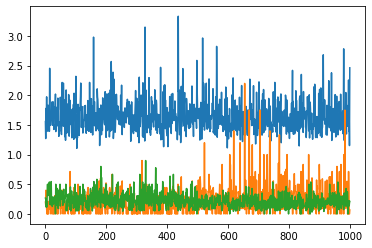

In [24]:
# using SVM or perceptron to train metric_MI:
train_coco = COCO("data/annotations/captions_train2014.json")
val_coco = COCO("data/annotations/captions_val2014.json")
train_ids = list(train_coco.anns.keys())
val_ids = list(val_coco.anns.keys())
random.shuffle(train_ids)
random.shuffle(val_ids)
# print(in_sample[0])
MI_data = [] 
MI_label = []
a = 1.0
b = 1.0
sample_size = 500
# get sample in 'in' set
for i in range(sample_size):
    annsid = train_ids[i]
    img_id = train_coco.anns[annsid]['image_id']
    caption = train_coco.anns[annsid]['caption']
    image_path = "data/train2014/" + train_coco.loadImgs(img_id)[0]['file_name']
    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    ori_caption = []
    ori_caption_nostopwords = []
    ori_caption.extend([token for token in tokens])
    ori_caption_nostopwords.extend([token for token in tokens if not token in stopwords.words()])
    (a,b,gen_caption) = perplexity(image_path)
    gen_caption_nostopwords = []
    gen_caption_nostopwords.extend([token for token in gen_caption if not token in stopwords.words()])
    similarity = jaccard(ori_caption, gen_caption)
    comp_length = abs(len(ori_caption)-len(gen_caption))/len(ori_caption)*1.0
    MI_data.append([a, b, comp_length, similarity])
    MI_label.append(1)
# get sample in 'out' set
for i in range(sample_size):
    image_id = flickr[i][0]
    caption = flickr[i][1]
    image_path = 'archive/Images/' + image_id
    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    ori_caption = []
    ori_caption_nostopwords = []
    ori_caption.extend([token for token in tokens])
    ori_caption_nostopwords.extend([token for token in tokens if not token in stopwords.words()])
    (a,b,gen_caption) = perplexity(image_path)
    gen_caption_nostopwords = []
    gen_caption_nostopwords.extend([token for token in gen_caption if not token in stopwords.words()])
    similarity = jaccard(ori_caption, gen_caption)
    comp_length = abs(len(ori_caption)-len(gen_caption))/len(ori_caption)*1.0
    MI_data.append([a, b, comp_length,similarity])
    MI_label.append(-1)
data_train = np.array(MI_data)
label_train = np.array(MI_label)
index = np.array(list(range(sample_size*2)))
plt.plot(index, MI_data)

In [29]:
model = svm.SVC(kernel='linear', C=10000)
model.fit(data_train, label_train)
print("accuracy of linear SVM is :")
print(model.score(data_test, label_test))

accuracy of linear SVM is :
0.6175


In [66]:
# feature vector base MI
random.shuffle(train_ids)
random.shuffle(val_ids)
# print(in_sample[0])
image_feature = [] 
words_feature = []
MI_label = []
a = 1.0
b = 1.0
ids = []
sample_size = 500
# get sample in 'in' set
for i in range(sample_size):
    annsid = train_ids[i]
    img_id = train_coco.anns[annsid]['image_id']
    caption = train_coco.anns[annsid]['caption']
    image_path = "data/train2014/" + train_coco.loadImgs(img_id)[0]['file_name']
    (i_feature,w_feature) = getting_feature(image_path)
    image_feature.append(i_feature)
    words_feature.append(w_feature)
    MI_label.append(1)
# get sample in 'out' set
for i in range(sample_size):
    image_id = flickr[i][0]
    caption = flickr[i][1]
    image_path = 'archive/Images/' + image_id
    (i_feature,w_feature) = getting_feature(image_path)
    image_feature.append(i_feature)
    words_feature.append(w_feature)
    MI_label.append(-1)

image_feature = np.array(image_feature)
words_feature = np.array(words_feature)
label_train = np.array(MI_label)
index = np.array(list(range(sample_size*2)))
print(image_feature.shape)
print(words_feature.shape)

(1000, 256)
(1000, 9956)


In [69]:
# using PCA to reduce dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=256)
pca.fit(words_feature)
d_words_feature = pca.transform(words_feature)
print(d_words_feature.shape)

(1000, 256)


In [70]:
def cosine_distance(a, b):
    if a.shape != b.shape:
        raise RuntimeError("array {} shape not match {}".format(a.shape, b.shape))
    if a.ndim==1:
        a_norm = np.linalg.norm(a)
        b_norm = np.linalg.norm(b)
    elif a.ndim==2:
        a_norm = np.linalg.norm(a, axis=1, keepdims=True)
        b_norm = np.linalg.norm(b, axis=1, keepdims=True)
    else:
        raise RuntimeError("array dimensions {} not right".format(a.ndim))
    similiarity = np.dot(a, b.T)/(a_norm * b_norm) 
    dist = 1. - similiarity
    return dist

In [71]:
#test
cosine_distance(image_feature[0],d_words_feature[0])

0.9840912663095178

In [73]:
# calculate all the similarities
Sim_I_W = []
for i in range(sample_size*2):
    sim = cosine_distance(image_feature[i], d_words_feature[i])
    Sim_I_W.append(sim)
Sim_I_W = np.array(Sim_I_W)

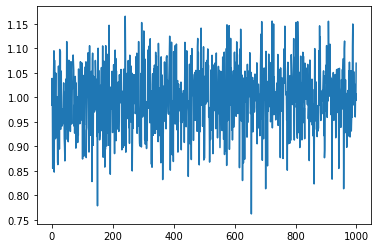

In [74]:
plt.plot(index, Sim_I_W)

In [76]:
train_data = Sim_I_W.reshape(-1,1)
model = svm.SVC(kernel='linear', C=1e7)
model.fit(train_data, label_train)
print("accuracy of sklearn linear SVM is :")
print(model.score(train_data, label_train))

accuracy of sklearn linear SVM is :
0.518
